In [1]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)], sys.version_info(major=3, minor=8, micro=0, releaselevel='final', serial=0) 
Pytorch version: 1.9.0+cu111 


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Tue_Sep_15_19:12:04_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.1, V11.1.74
Build cuda_11.1.relgpu_drvr455TC455_06.29069683_0


In [1]:
%cd yolov7
!python export.py --weights ./YOLOv5s.pt --grid --simplify --include-nms 

D:\Dev\YOLOv7ConveyorObjectDetection\yolov7
Namespace(batch_size=1, conf_thres=0.25, device='cpu', dynamic=False, dynamic_batch=False, end2end=False, fp16=False, grid=True, img_size=[640, 640], include_nms=True, int8=False, iou_thres=0.45, max_wh=None, simplify=True, topk_all=100, weights='./YOLOv5s.pt')


YOLOR  2b811c6 torch 1.9.0+cu111 CPU

Traceback (most recent call last):
  File "export.py", line 47, in <module>
    model = attempt_load(opt.weights, map_location=device)  # load FP32 model
  File "D:\Dev\YOLOv7ConveyorObjectDetection\yolov7\models\experimental.py", line 252, in attempt_load
    ckpt = torch.load(w, map_location=map_location)  # load
  File "C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\serialization.py", line 607, in load
    return _load(opened_zipfile, map_location, pickle_module, **pickle_load_args)
  File "C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\serialization.py", line 882, in _load
    result = unpickler.load()
  File "C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\serialization.py", line 875, in find_class
    return super().find_class(mod_name, name)
AttributeError: Can't get attribute 'DetectionModel' on <module 'models.yolo' from 'D:\\Dev\\YOLOv7ConveyorObjectD

In [2]:
%cd ../
# !git clone https://github.com/Linaom1214/tensorrt-python.git

D:\Dev\YOLOv7ConveyorObjectDetection


In [3]:
%cd tensorrt-python
!dir

D:\Dev\YOLOv7ConveyorObjectDetection\tensorrt-python
 Volume in drive D is MAIN
 Volume Serial Number is E2C1-0EB0

 Directory of D:\Dev\YOLOv7ConveyorObjectDetection\tensorrt-python

15/02/2023  11:37 PM    <DIR>          .
15/02/2023  11:37 PM    <DIR>          ..
02/02/2023  05:49 PM    <DIR>          cpp
02/02/2023  05:49 PM            15,699 export.py
02/02/2023  05:49 PM             7,900 image_batch.py
02/02/2023  05:49 PM             5,232 README.md
02/02/2023  05:49 PM             1,164 README_CN.md
02/02/2023  05:49 PM    <DIR>          src
02/02/2023  05:49 PM             1,213 trt.py
02/02/2023  05:49 PM    <DIR>          utils
02/02/2023  05:57 PM        36,732,342 yolov7-tiny-nms.trt
08/02/2023  02:06 PM       212,527,322 YOLOv7.trt
10/02/2023  10:32 PM       217,693,423 YOLOv7Segmentation.trt
15/02/2023  07:51 PM        35,879,183 YOLOv7Tiny.trt
15/02/2023  10:18 PM        36,060,002 YOLOv7TinyVer2.trt
15/02/2023  11:37 PM        35,869,490 YOLOv7TinyVer3.trt
07/02/2023 

In [4]:
!python export.py -o ../yolov7/YOLOv5.onnx -e ./YOLOv7TinyVer3.trt -p fp16

[02/15/2023-23:32:49] [TRT] [I] [MemUsageChange] Init CUDA: CPU +236, GPU +0, now: CPU 8585, GPU 788 (MiB)
[02/15/2023-23:32:51] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +130, GPU +22, now: CPU 9203, GPU 810 (MiB)
[02/15/2023-23:32:51] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[02/15/2023-23:32:51] [TRT] [W] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[02/15/2023-23:32:51] [TRT] [W] onnx2trt_utils.cpp:403: One or more weights outside the range of INT32 was clamped
[02/15/2023-23:32:51] [TRT] [I] No importer registered for op: EfficientNMS_TRT. Attempting to import as plugin.
[02/15/2023-23:32:51] [TRT] [I] Searching for plugin: EfficientNMS_TRT, plugin_version: 1, plugin_namespace: 
[02/15/20

In [1]:
import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
import cv2

class BaseEngine(object):
    def __init__(self, engine_path, imgsz=(640,640)):
        self.imgsz = imgsz
        self.mean = None
        self.std = None
        self.class_names = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]
        logger = trt.Logger(trt.Logger.WARNING)
        trt.init_libnvinfer_plugins(logger,'')
        runtime = trt.Runtime(logger)
        with open(engine_path, "rb") as f:
            serialized_engine = f.read()
        engine = runtime.deserialize_cuda_engine(serialized_engine)
        self.context = engine.create_execution_context()
        self.inputs, self.outputs, self.bindings = [], [], []
        self.stream = cuda.Stream()
        for binding in engine:
            size = trt.volume(engine.get_binding_shape(binding))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            self.bindings.append(int(device_mem))
            if engine.binding_is_input(binding):
                self.inputs.append({'host': host_mem, 'device': device_mem})
            else:
                self.outputs.append({'host': host_mem, 'device': device_mem})
                
    def infer(self, img):
        self.inputs[0]['host'] = np.ravel(img)
        # transfer data to the gpu
        for inp in self.inputs:
            cuda.memcpy_htod_async(inp['device'], inp['host'], self.stream)
        # run inference
        self.context.execute_async_v2(
            bindings=self.bindings,
            stream_handle=self.stream.handle)
        # fetch outputs from gpu
        for out in self.outputs:
            cuda.memcpy_dtoh_async(out['host'], out['device'], self.stream)
        # synchronize stream
        self.stream.synchronize()

        data = [out['host'] for out in self.outputs]
        return data

    def inference(self, img_path, conf=0.25):
        origin_img = cv2.imread(img_path)
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
        img, ratio = preproc(origin_img, self.imgsz, self.mean, self.std)
        num, final_boxes, final_scores, final_cls_inds = self.infer(img)
        final_boxes = np.reshape(final_boxes, (-1, 4))
        num = num[0]
        if num >0:
            final_boxes, final_scores, final_cls_inds = final_boxes[:num]/ratio, final_scores[:num], final_cls_inds[:num]
            origin_img = vis(origin_img, final_boxes, final_scores, final_cls_inds,
                             conf=conf, class_names=self.class_names)
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_RGB2BGR)                      
        return origin_img

    def get_fps(self):
        # warmup
        import time
        img = np.ones((1,3,self.imgsz[0], self.imgsz[1]))
        img = np.ascontiguousarray(img, dtype=np.float32)
        for _ in range(20):
            _ = self.infer(img)
        t1 = time.perf_counter()
        _ = self.infer(img)
        print(1/(time.perf_counter() - t1), 'FPS')

def preproc(image, input_size, mean, std, swap=(2, 0, 1)):
    if len(image.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3)) * 114.0
    else:
        padded_img = np.ones(input_size) * 114.0
    img = np.array(image)
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.float32)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img[:, :, ::-1]
    padded_img /= 255.0
    if mean is not None:
        padded_img -= mean
    if std is not None:
        padded_img /= std
    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


_COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.286, 0.286, 0.286,
        0.429, 0.429, 0.429,
        0.571, 0.571, 0.571,
        0.714, 0.714, 0.714,
        0.857, 0.857, 0.857,
        0.000, 0.447, 0.741,
        0.314, 0.717, 0.741,
        0.50, 0.5, 0
    ]
).astype(np.float32).reshape(-1, 3)


def vis(img, boxes, scores, cls_ids, conf=0.5, class_names=None):
    for i in range(len(boxes)):
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]
        if score < conf:
            continue
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        color = (_COLORS[cls_id % 80] * 255).astype(np.uint8).tolist()
        text = '{}:{:.1f}%'.format(class_names[cls_id], score * 100)
        txt_color = (0, 0, 0) if np.mean(_COLORS[cls_id % 80]) > 0.5 else (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX

        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)

        txt_bk_color = (_COLORS[cls_id % 80] * 255 * 0.7).astype(np.uint8).tolist()
        cv2.rectangle(
            img,
            (x0, y0 + 1),
            (x0 + txt_size[0] + 1, y0 + int(1.5 * txt_size[1])),
            txt_bk_color,
            -1
        )
        cv2.putText(img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color, thickness=1)

    return img

In [11]:
%cd ./tensorrt-python

D:\Dev\YOLOv7ConveyorObjectDetection\tensorrt-python


In [12]:
pred = BaseEngine(engine_path='../tensorrt-python/yolov7-tiny-nms.trt')
origin_img = pred.inference('../yolov7/inference/images/horses.jpg')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11000\2975521321.py:31: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(engine.get_binding_shape(binding))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11000\2975521321.py:32: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(engine.get_binding_dtype(binding))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11000\2975521321.py:36: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):


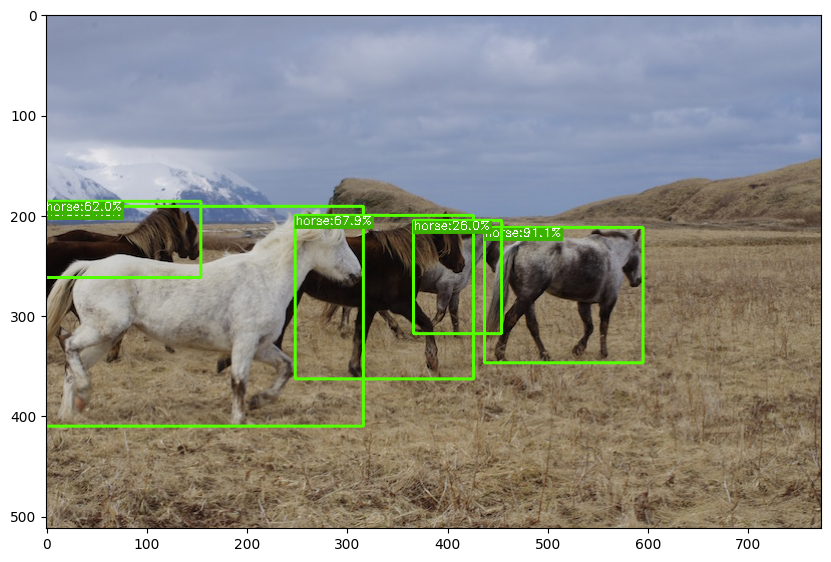

In [13]:
import  matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(origin_img[:, :, ::-1])

In [14]:
pred.get_fps()

66.38695629076462 FPS
